# Example: Properties

#### Imports

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import dxtb

#### Functions

In [30]:
# https://wiki.fysik.dtu.dk/ase/_modules/ase/vibrations/vibrations.html#Vibrations.fold
def fold(
    frequencies,
    intensities,
    start=800.0,
    end=4000.0,
    npts=None,
    width=4.0,
    type="Gaussian",
    normalize=True,
):
    """
    Fold frequencies and intensities within the given range
    and folding method (Gaussian/Lorentzian).
    The energy unit is cm^-1.
    normalize=True ensures the integral over the peaks to give the
    intensity.
    """

    lctype = type.lower()
    assert lctype in ["gaussian", "lorentzian"]

    if not npts:
        npts = int((end - start) / width * 10 + 1)

    prefactor = 1
    if lctype == "lorentzian":
        intensities = intensities * width * np.pi / 2.0
        if normalize:
            prefactor = 2.0 / width / np.pi
    else:
        sigma = width / 2.0 / np.sqrt(2.0 * np.log(2.0))
        if normalize:
            prefactor = 1.0 / sigma / np.sqrt(2 * np.pi)

    # Make array with spectrum data
    spectrum = np.empty(npts)
    energies = np.linspace(start, end, npts)
    for i, energy in enumerate(energies):
        energies[i] = energy
        if lctype == "lorentzian":
            spectrum[i] = (
                intensities
                * 0.5
                * width
                / np.pi
                / ((frequencies - energy) ** 2 + 0.25 * width**2)
            ).sum()
        else:
            spectrum[i] = (
                intensities * np.exp(-((frequencies - energy) ** 2) / 2.0 / sigma**2)
            ).sum()
    return [energies, prefactor * spectrum]


In [31]:
# from CCCBDB (calculated frequencies and vibrational properties for H2O)
HF_FREQ = np.array([3944.0, 3811.0, 1800.0])
HF_INTS = np.array([9.123e00, 4.7e-02, 7.989e01])

# xtb h2o/coord --gfn 1 --hess
REF_FREQ = np.array([1480.0601, 3643.9749, 3747.3581])
REF_INTS = np.array([232.8048, 45.4997, 45.5097])


In [32]:
numbers = torch.tensor([8, 1, 1])
positions = torch.tensor(
    [
        [+0.00000000000000, +0.00000000000000, -0.74288549752983],
        [-1.43472674945442, +0.00000000000000, +0.37144274876492],
        [+1.43472674945442, +0.00000000000000, +0.37144274876492],
    ]
)
charge = torch.tensor(0.0)

# position gradient for intensities
positions.requires_grad_(True)

# dipole moment requires electric field
field_vector = torch.tensor([0.0, 0.0, 0.0])
ef = dxtb.external.field.new_efield(field_vector)

calc = dxtb.Calculator(numbers, dxtb.GFN1_XTB, interaction=[ef])
freqs, ints = calc.ir_spectrum(numbers, positions, chrg=charge)

freqs, ints = freqs.detach().numpy(), ints.detach().numpy()


iter  energy                   energy change  P norm change   charge change  
-----------------------------------------------------------------------------
  1   -5.8041014671325684E+00   1.005300E+01  3.457256E+00    9.763765E-01
  2   -5.8052034378051758E+00   1.101971E-03  5.830036E-02    4.791620E-02
  3   -5.8052492141723633E+00   4.577637E-05  1.415288E-02    1.172101E-02
  4   -5.8052506446838379E+00   1.430511E-06  5.094408E-04    4.215838E-04
  5   -5.8052482604980469E+00   2.384186E-06  5.444945E-05    4.509950E-05
  6   -5.8052506446838379E+00   2.384186E-06  3.649854E-05    3.024939E-05
  7   -5.8052477836608887E+00   2.861023E-06  2.399788E-06    1.598497E-06
  8   -5.8052487373352051E+00   9.536743E-07  1.733247E-06    8.107793E-07
-----------------------------------------------------------------------------
**********************Energy**********************

Contribution                 Energy in a.u.    
--------------------------------------------------
DispersionD3  

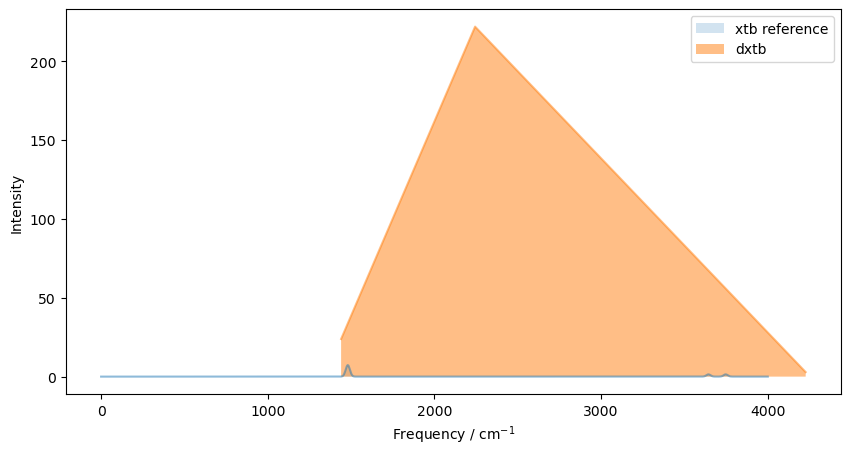

In [33]:
ref_freq, ref_ints = fold(
    REF_FREQ, REF_INTS, start=0.0, end=4000.0, width=30.0
)

dxtb_freq, dxtb_ints = fold(
    freqs, ints, start=0.0, end=4000.0, width=30.0
)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# Plot experimental data.
ax.plot(ref_freq, ref_ints, alpha=0.5)
ax.fill_between(ref_freq, ref_ints, label="xtb reference", alpha=0.2)

# Plot xtb data.
ax.plot(freqs, ints, alpha=0.5)
ax.fill_between(freqs, ints, label="dxtb", alpha=0.5)

plt.xlabel("Frequency / cm$^{-1}$")
plt.ylabel("Intensity")
plt.legend(loc="upper right")
plt.show()


# Taxol

In [34]:
x = """
     10.17      0.19264334
     26.52      0.26795287
     27.53      0.08055707
     32.91      0.43871903
     38.62      0.62131688
     49.59      0.18200738
     54.80      0.16204374
     64.46      0.09095641
     69.63      0.17315901
     76.56      0.37169700
     79.20      0.88418312
     88.04      0.16701145
     92.68      0.71380801
     98.98      0.84140985
    102.08      0.76277057
    106.75      5.25874937
    109.56      1.50978436
    119.90      0.51443810
    140.32      3.91561342
    143.42      2.18052197
    147.99      2.04179327
    148.74      1.66735775
    155.36      3.16580851
    166.03      0.53369219
    170.14      4.05271581
    174.54      0.53917418
    184.29      1.17517620
    190.30      1.33319998
    196.09      0.19881437
    199.35      2.96338864
    207.27      1.55739759
    213.33      0.58640598
    214.83      0.08852366
    228.44      1.72832318
    229.67      7.08114777
    247.52      4.58705731
    254.90      1.05994909
    257.32      0.61177908
    268.74      1.32466942
    273.40      2.27942836
    279.99      2.23370898
    290.19      5.56985355
    298.49      1.16944117
    302.20      5.31547885
    310.31      0.54524613
    324.10      3.47429986
    328.33      5.20848695
    333.50      9.83998972
    342.87      3.96259744
    347.03      8.26636444
    356.73      0.71811691
    368.78      4.64414601
    379.31      3.11639501
    381.35      0.05550082
    388.94      3.10635080
    395.61      5.28473829
    405.88      0.45812258
    410.41      8.44830720
    412.40      3.23075200
    413.01      4.01065418
    418.46      1.03622852
    419.22      0.27553929
    424.59      2.69422726
    425.38      2.23477442
    430.87      9.27390977
    434.50      2.12034664
    444.09      0.44739073
    451.37     16.33521787
    454.25      7.37195859
    466.41      3.61898913
    473.62      1.21520999
    485.03      3.23269606
    493.79      1.84328659
    504.00      9.79236566
    521.72     10.34142740
    523.96     31.49513235
    534.27     14.39045510
    546.01      5.07677983
    556.13      1.83044915
    567.01      1.01500016
    578.31      7.58126801
    580.08     22.35690734
    581.55     17.13792380
    585.09      0.73381463
    587.88     74.37161831
    593.59     19.48091000
    606.16      7.33975556
    610.12     10.74980665
    622.94      1.41781996
    633.54      0.59174364
    636.85      0.08400726
    639.12      2.66489166
    644.45      1.10314033
    650.00      4.83707972
    660.99     19.82167143
    668.06     50.56288813
    676.83     12.47959446
    684.32     18.99563608
    693.94     18.50175322
    709.24      7.77183332
    712.43      1.11557257
    714.79      4.37825327
    722.26      8.26146216
    736.22     49.56270186
    739.94     20.52738675
    742.16     17.15453054
    748.02      2.68224848
    750.34     44.92856623
    770.88     89.79032860
    781.62      8.26173255
    792.12     25.78656931
    798.66     51.15532329
    799.34     16.73559650
    806.05      4.22847005
    819.37     14.50979918
    829.37     34.40311123
    834.53     11.72106198
    845.67     23.20559216
    849.20      4.18247961
    855.36      8.13006522
    875.35      0.80457022
    892.88     12.36048028
    897.81      8.93508921
    899.01      7.53471665
    900.42      1.42737714
    910.94     12.29239264
    911.87      3.16681690
    922.75     13.05222981
    942.60      8.25398549
    948.87      9.04877765
    956.59      2.85722266
    973.38     32.78427965
    982.12     21.54144017
    988.02      3.94662839
    990.89      6.95796043
    992.72      3.44467729
   1000.49     10.06218850
   1015.02      1.59623033
   1018.38      3.40935140
   1027.78     21.40750295
   1031.96      5.35167102
   1033.89      0.44685680
   1034.21      0.04897343
   1036.67      1.62409029
   1037.74      3.41279861
   1038.34     41.71236997
   1038.59     16.44600477
   1045.88      2.50967195
   1046.77     42.28028763
   1049.30      0.10606793
   1050.38     20.28848862
   1056.30     10.68770766
   1057.77      1.78465303
   1058.76     29.84401456
   1065.17     17.63806063
   1067.47      1.91888661
   1070.07      7.90035449
   1072.32     15.45119852
   1074.18      5.77673299
   1077.81     13.96768451
   1078.56     13.00772700
   1080.78      0.50447174
   1083.76      1.79636695
   1085.20     11.39117857
   1094.51     23.09396497
   1105.93      9.18217127
   1117.35     25.59605274
   1123.94     50.81354429
   1125.38      7.74892457
   1126.32     10.16423675
   1127.19     16.26845542
   1132.17      6.36638190
   1135.00     46.07414982
   1137.54      0.25986481
   1152.41     25.40722002
   1159.65     36.57957700
   1165.85     72.58888581
   1177.02     17.87094415
   1188.57      3.46265843
   1188.92      0.82229150
   1189.86     11.97699850
   1191.73      2.73427717
   1198.13      0.82175542
   1199.92     18.18427567
   1207.26     58.09435484
   1219.46      6.79223496
   1221.93      2.51766813
   1223.24      2.06184051
   1224.85     13.25461870
   1228.61     29.01707542
   1232.03      2.67357185
   1234.40      9.27677074
   1235.12     15.32386879
   1244.27     39.91054704
   1248.55      4.90204608
   1256.77      6.94347780
   1271.50      9.05903204
   1274.15     11.07754813
   1277.55      0.91670888
   1296.41      7.81884946
   1299.41      1.39150273
   1311.40     13.34167549
   1316.28      0.40029869
   1323.46      8.14429146
   1326.69     10.29917355
   1331.02      1.80709805
   1344.38      9.04218878
   1346.02      7.01237818
   1350.50     21.56039333
   1354.01     35.81266037
   1367.82      8.88430722
   1372.34      0.95454284
   1372.92      1.98472834
   1378.67     88.15957895
   1381.73     11.79866029
   1384.82     22.48126539
   1386.75      6.22711365
   1394.64     70.19237030
   1396.11     35.95280477
   1399.87    105.09499115
   1403.62     39.31296384
   1404.22     47.45739482
   1409.25     28.48920386
   1412.07     43.68770247
   1414.27    282.74317325
   1420.32     40.17308671
   1424.42     16.06126054
   1431.68     19.31410564
   1439.01     26.80572185
   1441.38     45.92860953
   1446.91    176.80332272
   1450.38    298.42815473
   1459.02    403.04932296
   1461.69     47.63149797
   1465.15    312.44916920
   1473.83     46.70405799
   1484.66    116.94777033
   1485.32     63.22795514
   1500.50     15.87150283
   1502.09     14.86611348
   1502.47     30.64183096
   1504.44      5.15507204
   1508.59      9.78360708
   1511.87     17.32170301
   1512.63     16.27181227
   1516.70     45.34127071
   1517.54     21.70617286
   1521.22    137.66173073
   1522.25     27.88109686
   1523.32     19.62474334
   1524.29     44.91313214
   1525.07     71.93156351
   1528.20     36.87815397
   1528.92      2.32889338
   1533.00      2.75831896
   1542.72     13.35982448
   1558.53     21.86848172
   1563.51     29.13578034
   1567.47      3.54424541
   1567.97     23.13528994
   1573.74    120.48057963
   1575.67    241.02953134
   1678.14      4.92212762
   1679.58     15.28411056
   1687.75      0.48840144
   1707.74     25.80364433
   1710.36     14.04748956
   1713.96      1.47470982
   1737.27    519.40385097
   1741.57    193.44361948
   1749.78    215.07125831
   1764.90    357.16239080
   1774.56    244.52390773
   1792.81    225.54733585
   1823.49    195.61025620
   3029.34     20.58622798
   3042.94      5.53753910
   3060.48     12.89219049
   3079.48     16.68829152
   3086.21     14.80772856
   3088.99     12.23408344
   3093.81     27.77826664
   3093.95     28.46430719
   3095.05     10.63652219
   3098.33      8.12465557
   3104.17      4.42484127
   3110.72     21.58421633
   3114.71      9.87970023
   3130.43      4.44067188
   3137.70      6.39917799
   3141.46      6.04741260
   3144.54      2.19974954
   3148.22     10.60802686
   3157.56     12.46527369
   3160.65      1.91134741
   3167.07      1.71125969
   3170.24     14.35094189
   3170.60     14.13619739
   3171.18      6.21071205
   3181.25      1.48083225
   3184.21      6.10395499
   3186.76      0.28360555
   3187.59      0.10432949
   3190.53      3.86777589
   3193.01      0.92562012
   3195.26      2.87412707
   3197.18      6.68320054
   3202.31      6.05768969
   3203.06      7.51850597
   3203.69      7.20014952
   3204.41     10.47091101
   3207.79     17.09878400
   3210.41     11.67030078
   3211.98     10.40558261
   3214.33     14.60558217
   3216.77      7.41430624
   3218.00      5.29162324
   3218.12     11.34908058
   3226.77     34.62452245
   3229.88      3.46348403
   3237.30      1.26466862
   3266.75     17.66296308
   3379.06    934.41279813
   3555.17    241.88207226
   3560.91    212.90512794
   3628.02    129.67020702
"""

In [35]:
# Split the string into lines
lines = x.strip().split('\n')

# Split each line into freq and int values, and convert them to float
freqs, ints = [], []
for line in lines:
    freq, int_val = line.split()
    freqs.append(float(freq))
    ints.append(float(int_val))
    
# Convert lists to numpy arrays
freqs_taxol = np.array(freqs)
ints_taxol = np.array(ints)

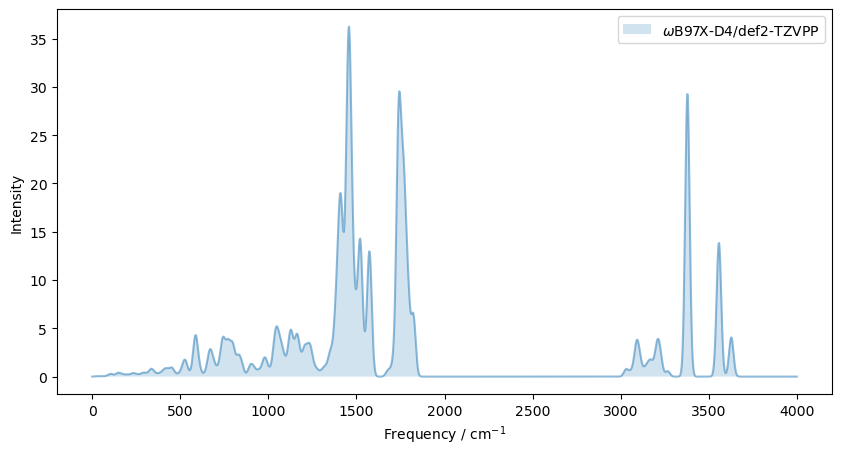

In [36]:
freqs_taxol, ints_taxol = fold(
    freqs_taxol, ints_taxol, start=0.0, end=4000.0, width=30.0
)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# Plot experimental data.
ax.plot(freqs_taxol, ints_taxol, alpha=0.5)
ax.fill_between(freqs_taxol, ints_taxol, label=r"$\omega$B97X-D4/def2-TZVPP", alpha=0.2)

plt.xlabel("Frequency / cm$^{-1}$")
plt.ylabel("Intensity")
plt.legend(loc="upper right")
plt.show()